## Example using IRIS dataset

In [1]:

import pandas as pd

from scivae import VAE, Validate
from sciviso import Scatterplot

# Set the location of the data
config = {'scale': False, # Whether to min max scale your data VAEs work best when data is pre-normalised & outliers removed for trainiing
           'batch_norm': True, 
          'loss': {'loss_type': 'mse', # mean squared error
           'distance_metric': 'mmd', # Maximum mean discrepency (can use kl but it works worse)
            'mmd_weight': 1}, 
          'encoding': {'layers': [{'num_nodes': 512, 'activation_fn': 'selu'}, # First layer of encoding
                                  {'num_nodes': 264, 'activation_fn': 'selu'}]}, # Second layer of encoding
          'decoding': {'layers': [{'num_nodes': 264, 'activation_fn': 'selu'},  # First layer of decoding
                                  {'num_nodes': 512, 'activation_fn': 'selu'}]}, # Second layer of decoding 
 'latent': {'num_nodes': 128}, 'optimiser': {'params': {}, 'name': 'adagrad'}} # Empty params means use default

# Path to the data
protein_df = pd.read_csv('/disk1/ariane/vscode/llms/data/uniprot/one_active_encoded.csv')
chem_df = pd.read_csv('/disk1/ariane/vscode/llms/data/embedded_reaction2EC.csv')



2024-07-31 15:05:10.503328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 15:05:10.635318: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 15:05:10.640701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-31 15:05:10.640714: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart d

In [2]:
import pickle
with open('/disk1/ariane/vscode/llms/scripts/proro/data_chem_embeddings_map.pkl', 'rb') as file:
    chem_df = pickle.load(file)

In [3]:
with open('/disk1/ariane/vscode/llms/notebooks/data_processing/protein_embeddings_map.pkl', 'rb') as file:
    protein_df = pickle.load(file)

In [4]:

with open('encoding_dict.pkl', 'rb') as file:
    protein_encodings = pickle.load(file)



(768,)

In [5]:
#protein_df = protein_df[~protein_df['EC number'].isna()]
ecs = []
for ec in protein_df['EC number']:
    added_in = False
    ec_values = [e.strip() for e in str(ec).split(';')]
    for e in ec_values:
        if '-' not in e:
            ecs.append(e)
            added_in = True
            break
    if not added_in:
        ecs.append(None)
protein_df['EC sorted'] = ecs



In [6]:
protein_df = protein_df[~protein_df['EC sorted'].isna()]

In [7]:
protein_df.set_index('EC sorted', inplace=True)

In [8]:
chem_df.set_index('EC number', inplace=True)

In [9]:
df = protein_df.join(chem_df, how='inner', lsuffix='_protein', rsuffix='_chem')
df

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Organism (ID),Sequence,Mass,...,encodings_protein,Residue,Embedding,Unnamed: 0,Reaction,Mapped Reaction,Reaction Text,id,uid_chem,encodings_chem
1.1.1.1,A5JYX5,reviewed,DHS3_CAEEL,Protein dhs-3 (Alcohol dehydrogenase dhs-3) (E...,dhs-3 T02E1.5,Caenorhabditis elegans,309,6239,MPYVFLLSPQLEIASQWDGYYEKTFEVSDHVHKEIILKVSGQTVLI...,33885,...,-,190,"[0.065312475, -0.12720262, 0.02317705, 0.01624...",0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,acetaldehyde + NADH + H+ = ethanol + NAD+ {r},0,0_0,"[0.1985072, 0.3913652, -1.0172747, -0.7870019,..."
1.1.1.1,A5JYX5,reviewed,DHS3_CAEEL,Protein dhs-3 (Alcohol dehydrogenase dhs-3) (E...,dhs-3 T02E1.5,Caenorhabditis elegans,309,6239,MPYVFLLSPQLEIASQWDGYYEKTFEVSDHVHKEIILKVSGQTVLI...,33885,...,-,190,"[0.065312475, -0.12720262, 0.02317705, 0.01624...",1,CC(C)(C)OC(=O)N1CCC(=O)C1.NC(=O)C1=CN([C@@H]2O...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,N-tert-butoxycarbonyl-3-pyrrolidinone + NADH +...,1,1_1,"[0.54382527, 0.18006772, -1.3707074, -0.940796..."
1.1.1.1,A5JYX5,reviewed,DHS3_CAEEL,Protein dhs-3 (Alcohol dehydrogenase dhs-3) (E...,dhs-3 T02E1.5,Caenorhabditis elegans,309,6239,MPYVFLLSPQLEIASQWDGYYEKTFEVSDHVHKEIILKVSGQTVLI...,33885,...,-,190,"[0.065312475, -0.12720262, 0.02317705, 0.01624...",2,CC(C)(C)OC(=O)N1CC[C@H](O)C1.NC(=O)c1ccc[n+]([...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,N-tert-butoxycarbonyl-3-pyrrolidinone + NADH +...,2,2_2,"[0.6653797, 0.12682098, -1.322369, -1.0984845,..."
1.1.1.1,A5JYX5,reviewed,DHS3_CAEEL,Protein dhs-3 (Alcohol dehydrogenase dhs-3) (E...,dhs-3 T02E1.5,Caenorhabditis elegans,309,6239,MPYVFLLSPQLEIASQWDGYYEKTFEVSDHVHKEIILKVSGQTVLI...,33885,...,-,190,"[0.065312475, -0.12720262, 0.02317705, 0.01624...",3,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[H+].[NH2:1][C:2](=[O:3])[C:4]1=[CH:5][N:6]([C...,p-nitrobenzyloxycarbonyl-3-pyrrolidinone + NAD...,3,3_3,"[0.46884793, 0.19486639, -1.5244821, -0.801477..."
1.1.1.1,A5JYX5,reviewed,DHS3_CAEEL,Protein dhs-3 (Alcohol dehydrogenase dhs-3) (E...,dhs-3 T02E1.5,Caenorhabditis elegans,309,6239,MPYVFLLSPQLEIASQWDGYYEKTFEVSDHVHKEIILKVSGQTVLI...,33885,...,-,190,"[0.065312475, -0.12720262, 0.02317705, 0.01624...",4,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,p-nitrobenzyloxycarbonyl-3-pyrrolidinone + NAD...,4,4_4,"[0.5718287, 0.39933217, -1.3793534, -0.7820365..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7.2.2.6,Q98GX6,reviewed,KDPB_RHILO,Potassium-transporting ATPase ATP-binding subu...,kdpB mll3130,Mesorhizobium japonicum (strain LMG 29417 / CE...,697,266835,MSQLKSSAIMDARILWPAFGGAFRKLDPRTLARNPVMFVVAIVSAL...,73406,...,-,306,"[0.05502787, -0.054667585, 0.014708043, -0.036...",59021,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,NaN,NaN,59021,59021_59021,"[0.9736377, 0.403096, -1.0319676, -0.84578073,..."
7.2.2.6,Q9A7X7,reviewed,KDPB_CAUVC,Potassium-transporting ATPase ATP-binding subu...,kdpB CC_1592,Caulobacter vibrioides (strain ATCC 19089 / CI...,686,190650,MSSPDIHADQGRRALAGGLSRAVLARAVKEAFLKLDPRQLTGNPVI...,71019,...,-,314,"[0.0814393, -0.10083906, -0.013683609, -0.0340...",59021,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,NaN,NaN,59021,59021_59021,"[0.9736377, 0.403096, -1.0319676, -0.84578073,..."
7.2.2.6,Q9R6X1,reviewed,KDPB_ANASL,Potassium-transporting ATPase ATP-binding subu...,kdpB,Anabaena sp. (strain L31),701,29412,MNPDAPTPKNKSSRSRPSDRPQARKKAKIKTKGIYLRAIGDAFVKL...,74359,...,-,329,"[0.03142822, -0.027820798, -0.020044627, -0.02...",59021,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,NaN,NaN,59021,59021_59021,"[0.9736377, 0.403096, -1.0319676, -0.84578073,..."
7.2.2.6,Q9RZP0,reviewed,KDPB_DEIRA,Potassium-transporting ATPase ATP-binding subu...,kdpB DR_B0083,Deinococcus radiodurans (strain ATCC 13939 / D...,675,243230,MTTAPQPKQSIFSPELVRGAVRASFAKLSPRDQARNPVMFVVYLGT..

In [10]:
df = df.drop_duplicates('Entry Name')
df

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Organism (ID),Sequence,Mass,...,encodings_protein,Residue,Embedding,Unnamed: 0,Reaction,Mapped Reaction,Reaction Text,id,uid_chem,encodings_chem
1.1.1.1,A5JYX5,reviewed,DHS3_CAEEL,Protein dhs-3 (Alcohol dehydrogenase dhs-3) (E...,dhs-3 T02E1.5,Caenorhabditis elegans,309,6239,MPYVFLLSPQLEIASQWDGYYEKTFEVSDHVHKEIILKVSGQTVLI...,33885,...,-,190,"[0.065312475, -0.12720262, 0.02317705, 0.01624...",0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,acetaldehyde + NADH + H+ = ethanol + NAD+ {r},0,0_0,"[0.1985072, 0.3913652, -1.0172747, -0.7870019,..."
1.1.1.1,P00334,reviewed,ADH_DROME,Alcohol dehydrogenase (EC 1.1.1.1),Adh CG3481,Drosophila melanogaster (Fruit fly),256,7227,MSFTLTNKNVIFVAGLGGIGLDTSKELLKRDLKNLVILDRIENPAA...,27761,...,-,153,"[-0.045373365, 0.0873662, 0.22921456, 0.309620...",0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,acetaldehyde + NADH + H+ = ethanol + NAD+ {r},0,0_0,"[0.1985072, 0.3913652, -1.0172747, -0.7870019,..."
1.1.1.1,P0A9Q7,reviewed,ADHE_ECOLI,Bifunctional aldehyde-alcohol dehydrogenase Ad...,adhE ana b1241 JW1228,Escherichia coli (strain K12),891,83333,MAVTNVAELNALVERVKKAQREYASFTQEQVDKIFRAAALAAADAR...,96127,...,-,246,"[0.023488857, -0.28916723, -0.017211566, 0.185...",0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,acetaldehyde + NADH + H+ = ethanol + NAD+ {r},0,0_0,"[0.1985072, 0.3913652, -1.0172747, -0.7870019,..."
1.1.1.1,P0A9Q8,reviewed,ADHE_ECO57,Bifunctional aldehyde-alcohol dehydrogenase Ad...,adhE Z2016 ECs1741,Escherichia coli O157:H7,891,83334,MAVTNVAELNALVERVKKAQREYASFTQEQVDKIFRAAALAAADAR...,96127,...,-,246,"[0.023488857, -0.28916723, -0.017211566, 0.185...",0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,acetaldehyde + NADH + H+ = ethanol + NAD+ {r},0,0_0,"[0.1985072, 0.3913652, -1.0172747, -0.7870019,..."
1.1.1.1,Q24803,reviewed,ADH2_ENTH1,Aldehyde-alcohol dehydrogenase 2 [Includes: Al...,ADH2 EHI_160940,Entamoeba histolytica (strain ATCC 30459 / HM-...,870,294381,MSTQQTMTVDEHINQLVAKAQVALKEYLKPEYTQEKIDYIVKKASV...,95590,...,-,252,"[0.019595526, -0.12722251, -0.023305424, 0.079...",0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,acetaldehyde + NADH + H+ = ethanol + NAD+ {r},0,0_0,"[0.1985072, 0.3913652, -1.0172747, -0.7870019,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7.2.2.6,Q98GX6,reviewed,KDPB_RHILO,Potassium-transporting ATPase ATP-binding subu...,kdpB mll3130,Mesorhizobium japonicum (strain LMG 29417 / CE...,697,266835,MSQLKSSAIMDARILWPAFGGAFRKLDPRTLARNPVMFVVAIVSAL...,73406,...,-,306,"[0.05502787, -0.054667585, 0.014708043, -0.036...",59021,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,NaN,NaN,59021,59021_59021,"[0.9736377, 0.403096, -1.0319676, -0.84578073,..."
7.2.2.6,Q9A7X7,reviewed,KDPB_CAUVC,Potassium-transporting ATPase ATP-binding subu...,kdpB CC_1592,Caulobacter vibrioides (strain ATCC 19089 / CI...,686,190650,MSSPDIHADQGRRALAGGLSRAVLARAVKEAFLKLDPRQLTGNPVI...,71019,...,-,314,"[0.0814393, -0.10083906, -0.013683609, -0.0340...",59021,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,NaN,NaN,59021,59021_59021,"[0.9736377, 0.403096, -1.0319676, -0.84578073,..."
7.2.2.6,Q9R6X1,reviewed,KDPB_ANASL,Potassium-transporting ATPase ATP-binding subu...,kdpB,Anabaena sp. (strain L31),701,29412,MNPDAPTPKNKSSRSRPSDRPQARKKAKIKTKGIYLRAIGDAFVKL...,74359,...,-,329,"[0.03142822, -0.027820798, -0.020044627, -0.02...",59021,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,NaN,NaN,59021,59021_59021,"[0.9736377, 0.403096, -1.0319676, -0.84578073,..."
7.2.2.6,Q9RZP0,reviewed,KDPB_DEIRA,Potassium-transporting ATPase ATP-binding subu...,kdpB DR_B0083,Deinococcus radiodurans (strain ATCC 13939 / D...,675,243230,MTTAPQPKQSIFSPE

In [42]:
import numpy as np
df = df[~df['Embedding'].isna()]
chem_data = np.array([np.asarray(x).astype(np.float32) for x in df['encodings_chem'].values])
protein_data = np.array([np.asarray(x).astype(np.float32) for x in df['Embedding'].values])


In [41]:
chem_data.shape

(79617, 768)

In [27]:
protein_data[0].shape
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [43]:
# Build a simple vae to learn the relations in the iris dataset
loss = {'loss_type': 'multi', 'distance_metric': 'mmd', 'mmd_weight': 1, 'multi_loss': ['mse', 'mse']}
encoding = {'layers': [[{'num_nodes': 512, 'activation_fn': 'selu'},
                        {'num_nodes': 256, 'activation_fn': 'selu'}]]}  #, {'num_nodes': 3, 'activation_fn': 'relu'}]}
decoding = {'layers': [[{'num_nodes': 256, 'activation_fn': 'selu'}, 
                        {'num_nodes': 512, 'activation_fn': 'selu'}]]}
latent = {'num_nodes': 128}
optimisers = {'name': 'adam', 'params': {}}
config = {'loss': loss, 'encoding': encoding, 'decoding': decoding, 'latent': latent, 'optimiser': optimisers,
                  'input_size': [768, 1280], 'output_size': [768, 1280]}
# Set up what the columns are
vae = VAE([chem_data, protein_data], [chem_data, protein_data], df.index.values, config, 'vae')
vae.encode('default',  epochs=10, batch_size=500, train_percent=85.0, logging_dir=None, logfile=None,
               early_stop=True)

# Lets have a look at a scatterplot version & apply the class colours to our plot
encoding = vae.get_encoded_data()
decoding = vae.decoder.predict(encoding)

[768, 1280]
--------------------------------------------------------------------------------
                               Encoder summary:	                                
--------------------------------------------------------------------------------
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 default_input_0 (InputLayer)   [(None, 768)]        0           []                               
                                                                                                  
 default_input_1 (InputLayer)   [(None, 1280)]       0           []                               
                                                                                                  
 dense_30 (Dense)               (None, 512)          393728      ['default_input_0[0][0]']        
                                   

/disk1/ariane/miniconda3/envs/scivae/lib/python3.10/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


67674/67674 [==============================] - 38s 556us/sample - loss: 67.8886 - val_loss: nan
Epoch 2/10
67674/67674 [==============================] - 37s 541us/sample - loss: 25.1405 - val_loss: 24.6883
Epoch 3/10
67674/67674 [==============================] - 39s 582us/sample - loss: 24.1738 - val_loss: 22.2736
Epoch 4/10
67674/67674 [==============================] - 39s 575us/sample - loss: 25.3694 - val_loss: 22.8920
Epoch 5/10
67674/67674 [==============================] - 39s 572us/sample - loss: 25.2830 - val_loss: 23.4657
Epoch 6/10
67674/67674 [==============================] - 39s 577us/sample - loss: 24.0207 - val_loss: 24.2233
Epoch 7/10
67674/67674 [==============================] - 39s 574us/sample - loss: 25.6225 - val_loss: 25.5027
Epoch 8/10
67674/67674 [==============================] - 39s 574us/sample - loss: 26.5521 - val_loss: 25.1743
Epoch 9/10
67674/67674 [==============================] - 39s 571us/sample - loss: 26.3300 - val_loss: 23.6704


/disk1/ariane/miniconda3/envs/scivae/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


## Visualise the latent space

Visualise and colour the latent space.


/disk1/ariane/miniconda3/envs/scivae/lib/python3.10/site-packages/sciviso/scatterplot.py:115: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(vis_df[x].values, vis_df[y].values, c=self.colour, alpha=self.opacity,


<AxesSubplot: title={'center': 'Latent space coloured by class'}, xlabel='VAE 0', ylabel='VAE 1'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

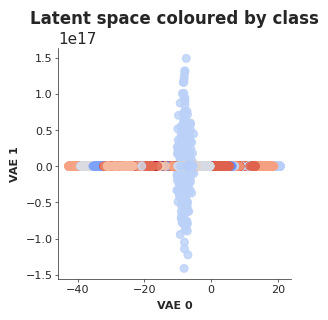

In [45]:
import seaborn as sns
vis_df = pd.DataFrame()
vis_df['latent_0'] = encoding[:, 0]
vis_df['latent_1'] = encoding[:, 1]
labels = df.index.values
lut = dict(zip(set(labels), sns.color_palette("coolwarm", len(set(labels)))))
row_colors2 = pd.DataFrame(labels)[0].map(lut)
vis_df['label'] = row_colors2
scatter = Scatterplot(vis_df, 'latent_0', 'latent_1', colour=row_colors2, title='Latent space coloured by class',
                      xlabel='VAE 0', ylabel='VAE 1')
scatter.plot()

## Print out the accuracy

Here we just get the accuracy of the encoding space when we use it as features for a classifier.

In [46]:
vd = Validate(encoding, labels)
#print(vd.predict('rf', 'accuracy')) # 0.3159318976209268 is not bad for a 8 class problem
print(vd.predict('svm', 'balanced_accuracy'))

In [1]:
print(vd.predict('svm', 'balanced_accuracy'))

NameError: name 'vd' is not defined